In [14]:
# !pip install optuna

In [79]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import optuna

-----------

# Reading a Dataset to Train a Model¶

In [81]:
data = pd.read_excel('final_dataset.xlsx')
data

,full_name,age,height,citizenship,player_agent,current_club,joined,outfitter,social_media,link,...,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount,Defender_Group,Midfielder_Group,Striker_Group,Winger_Group,followers
0,Joško Gvardiol,22.0,1.85,Croatia,1,Manchester City,7,0,"('Instagram', 'http://www.instagram.com/josko_...",https://www.transfermarkt.com/josko-gvardiol/p...,...,303,37.875,81,8,9,2,0,0,0,1199636
1,Nathan Benjamin Aké,29.0,1.80,Netherlands Cote d'Ivoire,1,Manchester City,43,1,http://www.instagram.com/nathanake/,https://www.transfermarkt.com/nathan-ake/profi...,...,303,37.875,81,8,9,2,0,0,0,2227475
2,Sergio Gómez Martín,23.0,1.71,Spain,1,Manchester City,18,0,http://www.instagram.com/sergiogm_10/,https://www.transfermarkt.com/sergio-gomez/pro...,...,303,37.875,81,8,9,1,0,0,1,475430
3,Kyle Andrew Walker,33.0,1.78,England,1,Manchester City,79,1,http://www.instagram.com/kylewalker2/,https://www.transfermarkt.com/kyle-walker/prof...,...,303,37.875,81,8,9,1,0,0,1,4911531
4,Matheus Luiz Nunes,25.0,1.83,Portugal Brazil,1,Manchester City,6,0,"('Instagram', 'http://www.instagram.com/matheu...",https://www.transfermarkt.com/matheus-nunes/pr...,...,303,37.875,81,8,9,0,2,0,0,447746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16135,João Vítor de Oliveira Florêncio,26.0,1.82,Brazil,0,Nadur Youngsters FC,8,0,NaN,https://www.transfermarkt.com/robinho/profil/s...,...,0,0.000,0,2,0,0,0,1,1,0
16136,Rafael Conrado Prudente,29.0,1.89,Brazil,0,Oratory Youths FC,1,0,NaN,https://www.transfermarkt.com/rafael-conrado/p...,...,0,0.000,0,2,0,0,0,2,0,0
16137,Johandre Jose Padilla Vasquez,26.0,1.82,Colombia,0,Ghajnsielem FC,2,0,NaN,https://www.transfermarkt.com/johandre-padilla...,...,0,0.000,0,2,0,2,0,0,0,0
16138,Cláudio Henrique da Silva Barboza,25.0,1.64,Brazil,0,Ghajnsielem FC,7,0,NaN,https://www.transfermarkt.com/claudio-murici/p...,...,0,0.000,0,2,0,0,0,1,1,0


In [75]:
print(f"Number of rows in the dataset: {data.shape[0]}")
print(f"Number of columns in the dataset: {data.shape[1]}")

Number of rows in the dataset: 16140
Number of columns in the dataset: 61


In [34]:
data = data.fillna(0)

print("Fill missing values with zero")
print("Missing values:", data_filled_zero.isna().sum().sum())

Fill missing values with zero
Missing values: 0


## Highlighting features and target

In [17]:
relevant_features = [
    'age',
     'height',
     'player_agent',
     'joined',
     'outfitter',
     'appearances',
     'goals',
     'assists',
     'substitutions_on',
     'substitutions_off',
     'yellow_cards',
     'red_cards',
     'penalty_goals',
     'minutes_played',
     'individual',
     'international',
     'national',
     'other',
     'national_status',
     'national_matches',
     'national_goals',
     'national_assists',
     'national_yellow_cards',
     'national_red_cards',
     'avg_injuries_per_season',
     'avg_injury_duration',
     'is_injured',
     'last_injury_date',
     'club_price',
     'club_statistics_matches',
     'club_statistics_goals',
     'club_statistics_pts',
     'club_league_top_rank',
     'club_league_lowest_rank',
     'club_league_mean_rank',
     'foot_left',
     'foot_right',
     'trophies_total_score',
     'trophies_average_score',
     'trophies_max_score',
     'trophies_min_score',
     'trophies_amount',
     'club_trophies_total_score',
     'club_trophies_average_score',
     'club_trophies_max_score',
     'club_trophies_min_score',
     'club_trophies_amount',
     'Defender_Group',
     'Midfielder_Group',
     'Striker_Group',
     'Winger_Group',
     'followers'
]

In [18]:
X = data[relevant_features]
y = data['current_price']

In [22]:
log_target = False  # True - apply target logarithm, False - do not apply

# Logarithm the target if necessary
if log_target:
    y = np.log1p(y)

In [23]:
# Display statistical summary of column or Series "y"
y.describe()

count    1.614000e+04
mean     2.307404e+06
std      7.959596e+06
min      1.000000e+04
25%      1.250000e+05
50%      3.000000e+05
75%      9.500000e+05
max      1.800000e+08
Name: current_price, dtype: float64

## Distribution of the Target Value

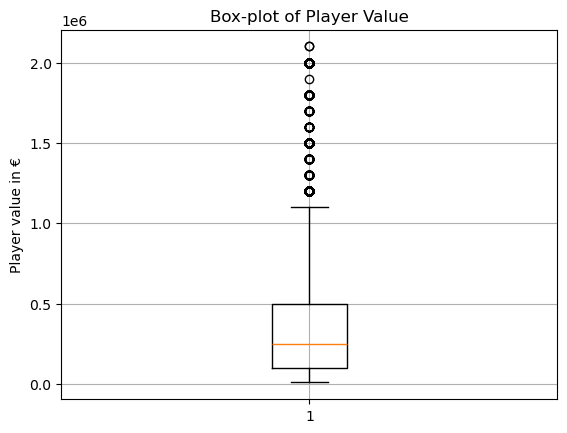

In [25]:
# Calculate the first (Q1) and third (Q3) quartiles of the data
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Filter data, remove anomalies
y_plot = y[~((y < (Q1 - 1.5 * IQR)) | (y > (Q3 + 1.5 * IQR)))]

# Build a box-plot of filtered data
plt.boxplot(y_plot)
if log_target:
    plt.ylabel("Logarithmic player value in €")
else:
    plt.ylabel("Player value in €")
plt.title("Box-plot of Player Value")
plt.grid(True)
plt.show()

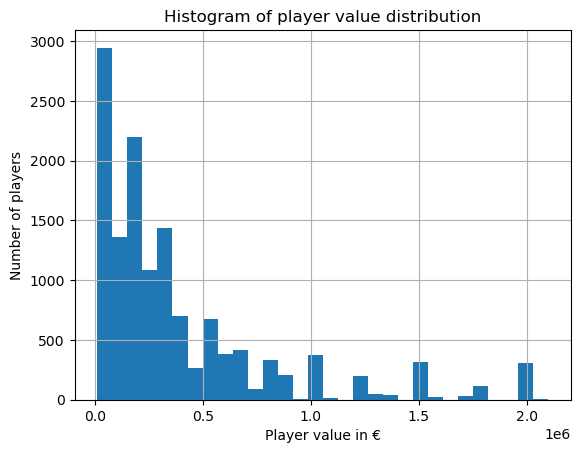

In [26]:
# Showing a histogram of player value distribution
plt.hist(y_plot, bins=30)
if log_target:
    plt.xlabel("Logarithmic player value in €")
else:
    plt.xlabel("Player value in €")
plt.ylabel("Number of players")
plt.title("Histogram of player value distribution")
plt.grid(True)
plt.show()

----

# Last Best Result

In [27]:
# Split the data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### optuna part

In [66]:
# Create a function to optimize the model parameters. 
# This function takes a trial from Optuna as input and returns the metric value (MAE) on the test sample.

def objective(trial):
    # Set the parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 500) # Suggest a value for the number of trees in the forest (between 100 and 500)
    max_features_options = trial.suggest_categorical('max_features', ['sqrt', 'log2', None]) # Suggest a value for the maximum number of features to consider for splitting a node
    
    # If 'None' is chosen for max_features, suggest a float value between 0.1 and 1.0
    if max_features_options is None:
        max_features = trial.suggest_float('max_features_frac', 0.1, 1.0)
    else:
        max_features = max_features_options
    
    max_depth = trial.suggest_int('max_depth', 10, 50, log=True)

    # Initialize the RandomForestRegressor with the suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_features=max_features,
        max_depth=max_depth,
        random_state=42
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Predict on the test data
    predictions = model.predict(X_test)
    
    # Calculate MAE of the predictions
    mae = mean_absolute_error(y_test, predictions)
    return mae

In [43]:
rf2 = RandomForestRegressor(random_state=42)
rf2.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [44]:
# Initial MAE Estimation
predictions = rf2.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')

MAE: 1115981.6294919455


In [45]:
# Optuna hyperparameter tuning
study2 = optuna.create_study(direction='minimize')
study2.optimize(objective, n_trials=100)

[I 2024-05-23 14:15:45,489] A new study created in memory with name: no-name-46f5677a-11a9-4f57-a1f5-8447add176e1
[I 2024-05-23 14:16:53,766] Trial 0 finished with value: 1112703.4776706784 and parameters: {'n_estimators': 482, 'max_features': None, 'max_features_frac': 0.9379298128502765, 'max_depth': 14}. Best is trial 0 with value: 1112703.4776706784.
[I 2024-05-23 14:17:05,042] Trial 1 finished with value: 1254903.0167584263 and parameters: {'n_estimators': 329, 'max_features': 'sqrt', 'max_depth': 20}. Best is trial 0 with value: 1112703.4776706784.
[I 2024-05-23 14:17:08,494] Trial 2 finished with value: 1265278.2214667602 and parameters: {'n_estimators': 128, 'max_features': 'sqrt', 'max_depth': 15}. Best is trial 0 with value: 1112703.4776706784.
[I 2024-05-23 14:17:34,914] Trial 3 finished with value: 1162238.4362769008 and parameters: {'n_estimators': 203, 'max_features': None, 'max_features_frac': 0.5617819604788529, 'max_depth': 42}. Best is trial 0 with value: 1112703.4776

In [61]:
best_params2 = study2.best_trial.params
best_params2

{'n_estimators': 418,
 'max_features': None,
 'max_features_frac': 0.9406014627190983,
 'max_depth': 20}

In [62]:
if 'max_features_frac' in best_params2:
    best_params2['max_features'] = best_params2.pop('max_features_frac')

In [63]:
best_rf = RandomForestRegressor(**best_params2, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=0.9406014627190983,
                      n_estimators=418, random_state=42)

In [76]:
best_predictions = best_rf.predict(X_test)

In [77]:
best_mae = mean_absolute_error(y_test, best_predictions)
print(f'Best MAE: {best_mae}')

Best MAE: 1104183.7807345195


In [80]:
r2 = r2_score(y_test, best_predictions)
print(f'R^2: {r2}')

R^2: 0.7890663325651335


### main body

In [67]:
X = data[relevant_features]
y = data['current_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(max_depth=20,
                                 max_features=0.9406014627190983, 
                                 n_estimators=418, 
                                 random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print(f'MAE: {mae}')

MAE: 1104183.7807345195


In [68]:
# для всего датасета
predicted_prices = rf_model.predict(X)
predicted_prices

array([4.99354067e+07, 4.61387560e+07, 1.11806220e+07, ...,
       1.61203257e+04, 4.67894758e+04, 1.26377883e+05])

In [69]:
rf_model.fit(X, y)

RandomForestRegressor(max_depth=20, max_features=0.9406014627190983,
                      n_estimators=418, random_state=42)

### save the model

In [70]:
import joblib
joblib.dump(rf_model, "rf_model.joblib")

['rf_model.joblib']

------